# Access ERA5 data from NCAR's OSDF origin using intake catalogs

In [1]:
#%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import intake
import xarray as xr
from distributed import LocalCluster, Client
from ncar_jobqueue import NCARCluster

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [3]:
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'

In [4]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '2:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

In [5]:
# Open collection description file using intake
catalog_url = 'https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json'
col         = intake.open_esm_datastore(catalog_url)
col

,unique
variable,78
long_name,75
component,5
experiment,4
frequency,6
vertical_levels,3
spatial_domain,5
units,25
start_time,12
end_time,13


In [6]:
# Use s3fs
s3     = s3fs.S3FileSystem(anon=True)

# List top-level directories and files in the 'ncar-cesm2-lens' bucket
bucket_contents = s3.ls('ncar-cesm2-lens/atm/monthly')
print(bucket_contents)

['ncar-cesm2-lens/atm/monthly/', 'ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-FLNS.zarr', 'ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-FLNSC.zarr', 'ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-FLUT.zarr', 'ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-FSNS.zarr', 'ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-FSNSC.zarr', 'ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-FSNTOA.zarr', 'ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-ICEFRAC.zarr', 'ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-LHFLX.zarr', 'ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-PRECC.zarr', 'ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-PRECL.zarr', 'ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-PRECSC.zarr', 'ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-PRECSL.zarr', 'ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-PS.zarr', 'ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-PSL.zarr', 'ncar-cesm2-lens/atm/monthly/ces

In [7]:
# Get data for the members which use the cmip6 prescription for biomass burning
store_hist_cmip6  = s3fs.S3Map(root='ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-TREFHT.zarr', s3=s3)
hist_cmip6     = xr.open_zarr(store_hist_cmip6)['TREFHT']
hist_cmip6

<xarray.DataArray 'TREFHT' (member_id: 50, time: 1980, lat: 192, lon: 288)> Size: 22GB
dask.array<open_dataset-TREFHT, shape=(50, 1980, 192, 288), dtype=float32, chunksize=(1, 600, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

In [8]:
# Get the corresponding future data which uses ssp370 pathway
store_ssp370_cmip6  = s3fs.S3Map(root='ncar-cesm2-lens/atm/monthly/cesm2LE-ssp370-cmip6-TREFHT.zarr', s3=s3)
ssp370_cmip6     = xr.open_zarr(store_ssp370_cmip6)['TREFHT']
ssp370_cmip6

<xarray.DataArray 'TREFHT' (member_id: 50, time: 1032, lat: 192, lon: 288)> Size: 11GB
dask.array<open_dataset-TREFHT, shape=(50, 1032, 192, 288), dtype=float32, chunksize=(1, 600, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

### Merge the data

In [9]:
ds_cmip6 = xr.concat([hist_cmip6,ssp370_cmip6],dim='time')
ds_cmip6

<xarray.DataArray 'TREFHT' (member_id: 50, time: 3012, lat: 192, lon: 288)> Size: 33GB
dask.array<concatenate, shape=(50, 3012, 192, 288), dtype=float32, chunksize=(1, 600, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 24kB 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

In [10]:
# GMST function ###
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time','member_id'}
    return (ds * weight).mean(other_dims)

In [11]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.98:37747,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


In [12]:
cluster.scale(8)
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.98:37747,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


### Calculate GMST 

#### Now compute (spatially weighted) Global Mean

In [13]:
ds_cmip6_annual = ds_cmip6.resample(time='AS').mean()
ds_cmip6_annual

<xarray.DataArray 'TREFHT' (member_id: 50, time: 251, lat: 192, lon: 288)> Size: 3GB
dask.array<transpose, shape=(50, 251, 192, 288), dtype=float32, chunksize=(1, 1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 2kB 1850-01-01 00:00:00 ... 2100-01-01 00:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

In [14]:
%%time
gmst_cmip6 = global_mean(ds_cmip6_annual)
gmst_cmip6 = gmst_cmip6.rename('gmst')
gmst_cmip6

CPU times: user 201 ms, sys: 992 µs, total: 202 ms
Wall time: 203 ms


<xarray.DataArray 'gmst' (member_id: 50, time: 251)> Size: 100kB
dask.array<mean_agg-aggregate, shape=(50, 251), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 2kB 1850-01-01 00:00:00 ... 2100-01-01 00:00:00

In [15]:
# %%time
# gmst_cmip6.to_dataset().to_zarr(rda_scratch + 'cesm2/gmst_cmip6.zarr',mode='w')

In [16]:
%%time
gmst_cmip6 = xr.open_zarr(rda_scratch + 'cesm2/gmst_cmip6.zarr').gmst
gmst_cmip6

CPU times: user 6.29 ms, sys: 0 ns, total: 6.29 ms
Wall time: 49.9 ms


<xarray.DataArray 'gmst' (member_id: 50, time: 251)> Size: 100kB
dask.array<open_dataset-gmst, shape=(50, 251), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 2kB 1850-01-01 00:00:00 ... 2100-01-01 00:00:00

### Compute anomaly and turn the result into a data frame

In [17]:
gmsta_cmip6 = gmst_cmip6 - gmst_cmip6.mean()

CPU times: user 24.6 s, sys: 1.48 s, total: 26.1 s
Wall time: 4min 8s


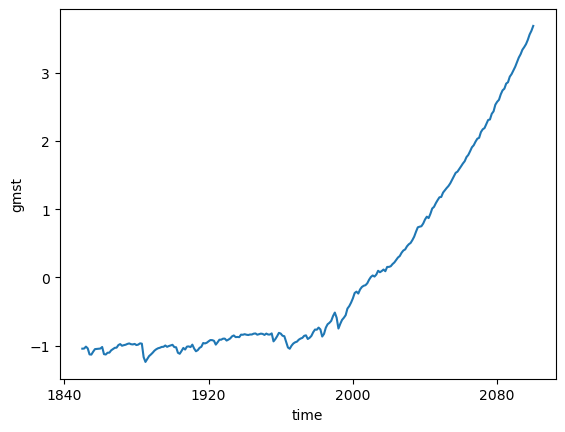

In [18]:
%%time
gmsta_cmip6.mean(dim='member_id').plot()

In [19]:
gmsta_cmip6_df = gmsta_cmip6.to_dataframe().reset_index()

In [20]:
gmsta_cmip6_df

,member_id,time,gmst
0,r10i1181p1f1,1850-01-01 00:00:00,-0.949268
1,r10i1181p1f1,1851-01-01 00:00:00,-0.917609
2,r10i1181p1f1,1852-01-01 00:00:00,-1.093474
3,r10i1181p1f1,1853-01-01 00:00:00,-1.193491
4,r10i1181p1f1,1854-01-01 00:00:00,-1.123225
...,...,...,...
12545,r9i1301p1f1,2096-01-01 00:00:00,3.316468
12546,r9i1301p1f1,2097-01-01 00:00:00,3.317616
12547,r9i1301p1f1,2098-01-01 00:00:00,3.426368
12548,r9i1301p1f1,2099-01-01 00:00:00,3.612411


ConversionError: Failed to convert value(s) to axis units: 0        1850-01-01 00:00:00
1        1851-01-01 00:00:00
2        1852-01-01 00:00:00
3        1853-01-01 00:00:00
4        1854-01-01 00:00:00
                ...         
12545    2096-01-01 00:00:00
12546    2097-01-01 00:00:00
12547    2098-01-01 00:00:00
12548    2099-01-01 00:00:00
12549    2100-01-01 00:00:00
Name: x, Length: 12550, dtype: object

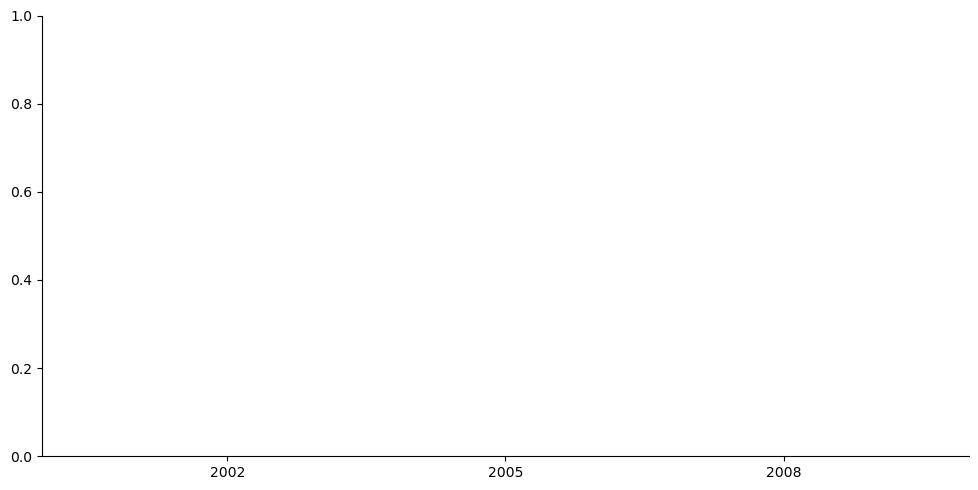

In [21]:
%%time
sns.relplot(data=gmsta_cmip6_df,
            x="time", y="gmst", hue='member_id',
            kind="line", ci="sd", aspect=2)